Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [14]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data


In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
## In Case using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')
#basepath ='/content/gdrive/MyDrive/CS_Data/MelanomaDetection'
#data_dir_train = pathlib.Path(basepath + '/Train')
#data_dir_test = pathlib.Path(basepath + '/Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [91]:
# Defining the path for train and test images
basepath ='../CNN_assignment/MelanomaDetection'
data_dir_train= pathlib.Path(basepath + '/Train')
data_dir_test=pathlib.Path(basepath + '/Test')

In [18]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [19]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [33]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    subset="training", 
    validation_split=0.2, 
    seed=123, 
    image_size=(img_height, img_width), 
    crop_to_aspect_ratio=False, 
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [34]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [35]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

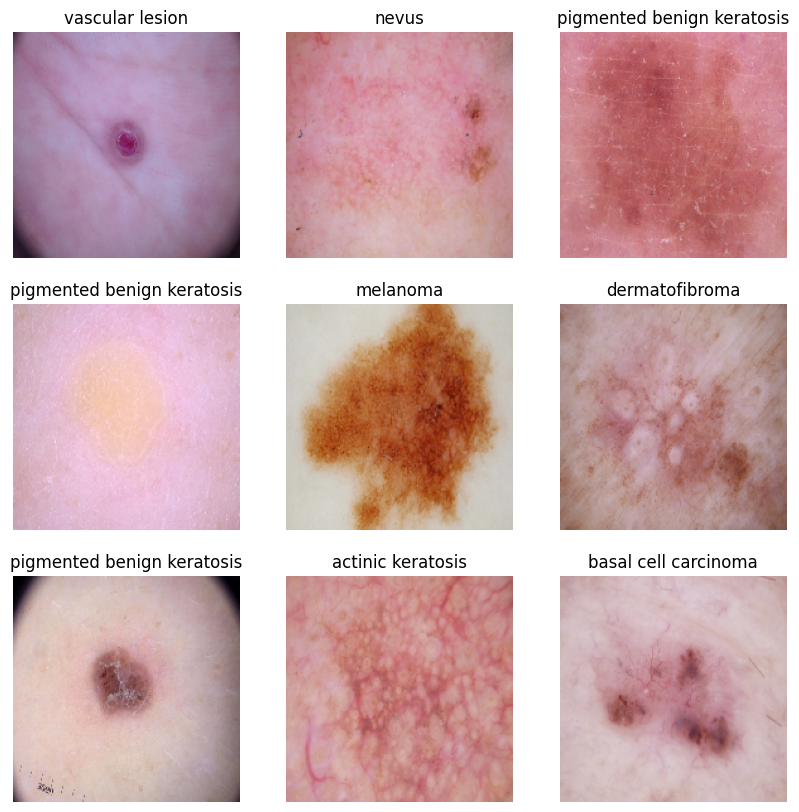

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


(32, 180, 180, 3)
(32,)


c:\Users\ASUS\Desktop\EPGP\.conda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [43]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [45]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 534ms/step - accuracy: 0.2988 - loss: 2.0675 - val_accuracy: 0.3468 - val_loss: 1.8824
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 447ms/step - accuracy: 0.4510 - loss: 1.5572 - val_accuracy: 0.5123 - val_loss: 1.5216
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 442ms/step - accuracy: 0.5139 - loss: 1.3980 - val_accuracy: 0.4944 - val_loss: 1.4283
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.5634 - loss: 1.2630 - val_accuracy: 0.5414 - val_loss: 1.3567
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 452ms/step - accuracy: 0.5971 - loss: 1.1806 - val_accuracy: 0.4720 - val_loss: 1.4651
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 439ms/step - accuracy: 0.5597 - loss: 1.1783 - val_accuracy: 0.5213 - val_loss: 1.3331
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 453ms/step - accuracy: 0.6550 - loss: 0.9674 - val_accuracy: 0.5168 - val_loss: 1.4146
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - accuracy: 0.6963 - loss: 0.8923 - val_accu

### Visualizing training results

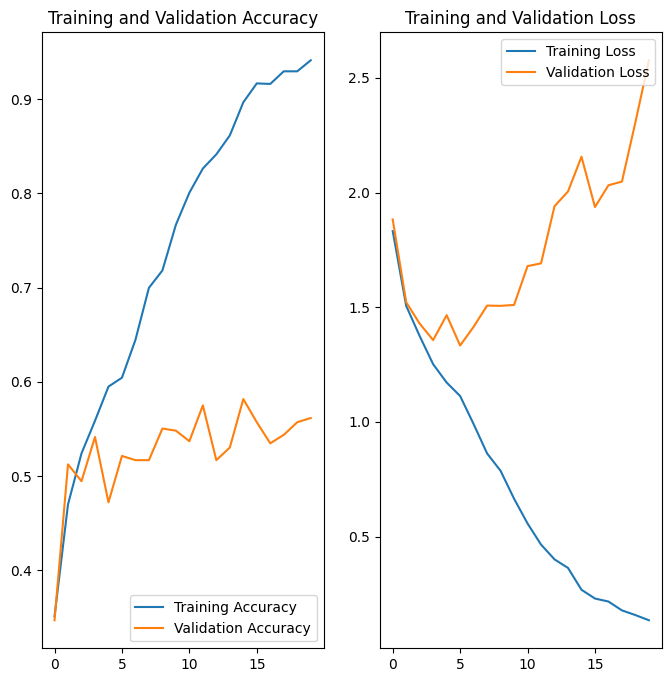

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
>  `Model is clearly a overfit as there is a big difference in accuracy between the training and the validation data.`

In [57]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, 
                                                              img_width,
                                                              3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

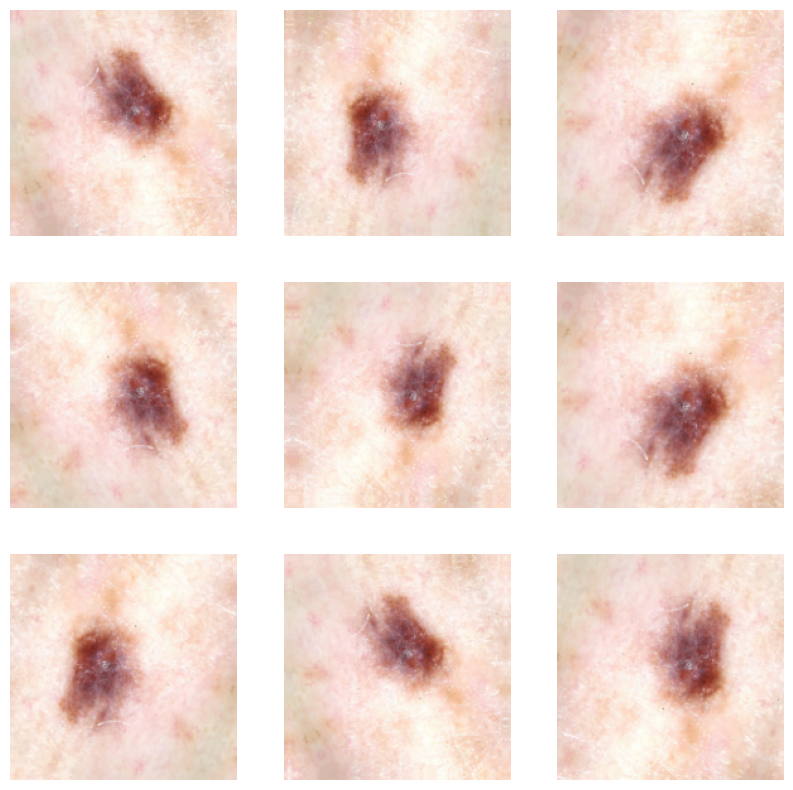

In [51]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [61]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## This is the technique to reduce overfitting is to introduce dropout regularization to the network.
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [62]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [63]:
## Train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 561ms/step - accuracy: 0.1913 - loss: 2.2845 - val_accuracy: 0.3937 - val_loss: 1.7824
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 600ms/step - accuracy: 0.3834 - loss: 1.7389 - val_accuracy: 0.4698 - val_loss: 1.5797
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 640ms/step - accuracy: 0.4613 - loss: 1.5427 - val_accuracy: 0.4385 - val_loss: 1.5572
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 580ms/step - accuracy: 0.4866 - loss: 1.4271 - val_accuracy: 0.4966 - val_loss: 1.4570
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 527ms/step - accuracy: 0.5057 - loss: 1.3936 - val_accuracy: 0.5190 - val_loss: 1.4252
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 526ms/step - accuracy: 0.5129 - loss: 1.3612 - val_accuracy: 0.5101 - val_loss: 1.4138
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 529ms/step - accuracy: 0.5236 - loss: 1.3433 - val_accuracy: 0.5213 - val_loss: 1.4231
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 538ms/step - accuracy: 0.5175 - loss: 1.3209 - val_accu

### Visualizing the results

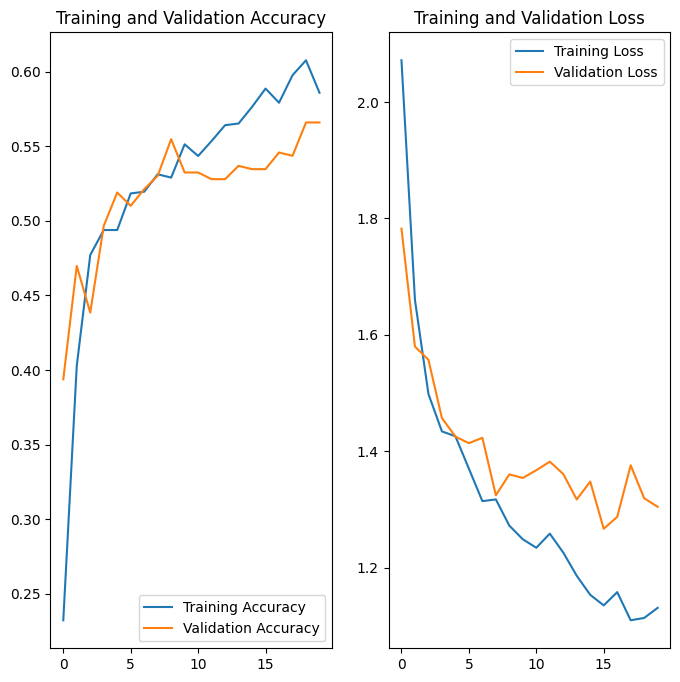

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
#Checking distribution of calsses in the data
folders = ([name for name in os.listdir(data_dir_train)
            if os.path.isdir(os.path.join(data_dir_train, name))]) 
for folder in folders:
    contents = os.listdir(os.path.join(data_dir_train,folder)) 
    print(folder+":"+str(len(contents)))

actinic keratosis:114
basal cell carcinoma:376
dermatofibroma:95
melanoma:438
nevus:357
pigmented benign keratosis:462
seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139


## Findings:
> +  `Seborrheic Keratosis, class has the least number of samples which are `**77**`in number.`
> +  `Pigmented Benign Keratosis, class dominate the data in terms proportionate to number of samples.`


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [66]:
!pip install Augmentor

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------------- ------------------------- 20.5/57.6 kB 41.0 kB/s eta 0:00:01
     ------------- ------------------------- 20.5/5

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [67]:
path_to_training_dataset=data_dir_train
print(path_to_training_dataset)
path_to_training_dataset= pathlib.Path(basepath + '/Train')
csp = str(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(csp + '/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

..\CNN_assignment\MelanomaDetection\Train
Initialised with 114 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x26504329D30>: 100%|██████████| 500/500 [00:07<00:00, 68.74 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26546087230>: 100%|██████████| 500/500 [00:23<00:00, 21.28 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26545D105F0>: 100%|██████████| 500/500 [00:26<00:00, 18.74 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x26545C7B0B0>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x26546049040>: 100%|██████████| 500/500 [01:16<00:00,  6.50 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x26504439A30>: 100%|██████████| 500/500 [00:23<00:00, 20.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x265461CD820>: 100%|██████████| 500/500 [00:40<00:00, 12.23 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2650DBCEB70>: 100%|██████████| 500/500 [00:20<00:00, 24.23 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ..\CNN_assignment\MelanomaDetection\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26545A4FD40>: 100%|██████████| 500/500 [00:24<00:00, 20.44 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [68]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [71]:
import glob

In [73]:
#import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['..\\CNN_assignment\\MelanomaDetection\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_222480e4-6550-488d-9341-585b17beb202.jpg',
 '..\\CNN_assignment\\MelanomaDetection\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5f8b99f2-e3fb-4e70-8083-2fc9a4500045.jpg',
 '..\\CNN_assignment\\MelanomaDetection\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_96866e1b-d3f2-4196-82d5-0c63a414e46e.jpg',
 '..\\CNN_assignment\\MelanomaDetection\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_d073d720-5f35-493b-aabe-fa59121c0167.jpg',
 '..\\CNN_assignment\\MelanomaDetection\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ddaf07be-6f58-4edd-ba12-cbf997994a45.jpg',
 '..\\CNN_assignment\\MelanomaDetection\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_b33a93e8-7f3c-4446-b6e6-53237e57839d.jpg',
 '..\\CNN_assignment\\Melano

In [75]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [76]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [84]:
dataframe_dict = dict(zip(path_list, dataframe_dict_new))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

new_df = pd.concat([original_df, df2], ignore_index=True)

In [85]:
new_df['Label'].value_counts()

Label
vascular lesion                                                                                                                          500
squamous cell carcinoma                                                                                                                  500
seborrheic keratosis                                                                                                                     500
pigmented benign keratosis                                                                                                               500
nevus                                                                                                                                    500
                                                                                                                                        ... 
..\CNN_assignment\MelanomaDetection\Train\melanoma\output\melanoma_original_ISIC_0000143.jpg_c4528bd4-37f9-4a1d-a752-67c3f3629a44.jpg      1
..\CNN_

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [86]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [92]:
data_dir_train= os.path.join(data_dir_train)
data_dir_train

'..\\CNN_assignment\\MelanomaDetection\\Train'

In [93]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [94]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [97]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

(32, 180, 180, 3)
(32,)


c:\Users\ASUS\Desktop\EPGP\.conda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [98]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [99]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 103s 598ms/step - accuracy: 0.2406 - loss: 2.0234 - val_accuracy: 0.4001 - val_loss: 1.6516
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 93s 547ms/step - accuracy: 0.4330 - loss: 1.4909 - val_accuracy: 0.4625 - val_loss: 1.3508
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 508ms/step - accuracy: 0.4793 - loss: 1.3715 - val_accuracy: 0.4803 - val_loss: 1.3751
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 91s 539ms/step - accuracy: 0.4844 - loss: 1.3268 - val_accuracy: 0.4981 - val_loss: 1.2952
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 90s 534ms/step - accuracy: 0.4947 - loss: 1.3024 - val_accuracy: 0.5167 - val_loss: 1.2582
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 87s 512ms/step - accuracy: 0.5468 - loss: 1.1804 - val_accuracy: 0.5278 - val_loss: 1.1768
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 91s 537ms/step - accuracy: 0.5259 - loss: 1.1871 - val_accuracy: 0.5122 - val_loss: 1.2404
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 511ms/step - accuracy: 0.5102 - loss: 

#### **Todo:**  Visualize the model results

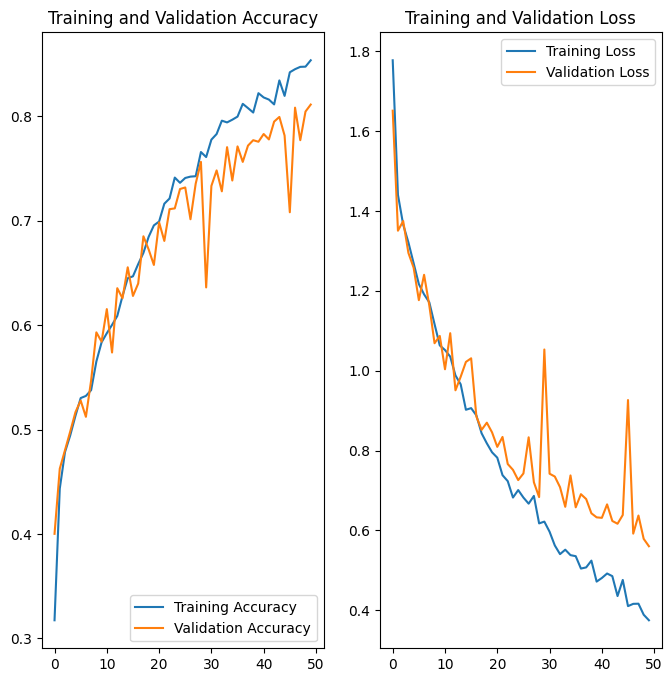

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze the results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



> `Yes, the overfitting problem is removed with the help of class rebalance.`